In [1]:
from scipy import integrate, interpolate
import numpy as np
import matplotlib.pyplot as plt
import ipyvolume as ipv

## TODO
 - Input parameters, get angle data for horizon (doable in cuda)
 - Input angle data, 2 images for horizon, get interpolated wormhole image 

# Simulating a single light path and the space time fabric


In [2]:
def z_integrand(l):
    x = 2/(np.pi*M) * (np.abs(l)-a)
    return np.sqrt(1-(2/np.pi)**2*np.arctan(x)**2)

def z_l(l):
    return integrate.quad(z_integrand, 0, l)[0]

def r_l(l):
    x = 2*(np.abs(l)-a)/(np.pi*M)
    if np.abs(l)>a:
        r = rho + M * (x*np.arctan(x) - 1/2*np.log(1+x**2))
        # drdl = 2/(np.pi)*np.arctan(x)*np.sign(l) 
    else:
        r = rho
    return r

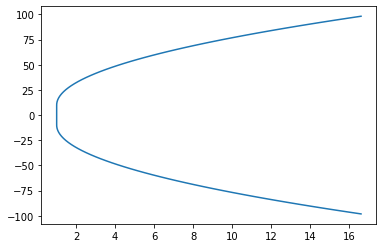

In [3]:
rho = 1 # wormhole radius
M = 100
a = 10


l_arr = np.linspace(-100,100, 100)
phi_arr = np.linspace(0, 2*np.pi, 10)
r_arr = np.array([r_l(l) for l in l_arr]) 

z_arr = np.array([z_l(l) for l in l_arr])

plt.plot(r_arr, z_arr)
plt.plot()

x_arr = np.array([ r*np.cos(phi) for r, phi in zip(r_arr, phi_arr)])
y_arr = np.array([ r*np.sin(phi) for r, phi in zip(r_arr, phi_arr)])



In [4]:
ipv.figure()
L = 100
L_iter = 30
phi_iter = 30
x_cord = []
y_cord = []
z_cord = []

for l in np.linspace(-L, L, L_iter):
    for phi in np.linspace(0, 2*np.pi, phi_iter):
        r = r_l(l)
        x = r*np.cos(phi)
        y = r*np.sin(phi)
        z = z_l(l)
        x_cord.append(x)
        y_cord.append(y)
        z_cord.append(z)

triangle_links1 = []
triangle_links2 = []
line_links = []

for j in range(L_iter-1):
    for i in range(int(phi_iter)):
        N = phi_iter
        triangle_links1.append([i+j*N, (i+1)+j*N, i+(j+1)*N])
        triangle_links2.append([i+j*N,  (i-1)+(j+1)*N,i+(j+1)*N])

        if i+1+j*N <= L_iter*phi_iter:
            line_links.append([i+j*N, i+1+j*N])
        if i+(j+1)*N <= L_iter*phi_iter:
            line_links.append([i+j*N, i+(j+1)*N])

# ipv.plot_trisurf(x_cord, y_cord, z_cord,
#        triangles=triangle_links1, color="#cc00b0")
# ipv.plot_trisurf(x_cord, y_cord, z_cord,
#        triangles=triangle_links2, color="#cc00b0")

ipv.plot_trisurf(x_cord, y_cord, z_cord,
        lines=line_links, color="#8100cc")

ipv.show()
#ipv.style.axes_off()
#ipv.style.box_off()

In [110]:
len(x_cord)

4500

In [ ]:
b = 1
B = b # plane relative to axis

In [42]:

def wormhole_diff(t, y, b, B):
    # y = l, th, phi, pl, pth
    l = y[0]
    th=y[1]
    phi = y[2]
    pl = y[3]
    pth = y[4]


    x = 2*(np.abs(l)-a)/(np.pi*M)
    r = r_l(l)
    drdl = np.arctan(x)*2/np.pi * np.sign(l)
    
    sth = np.sin(th)
    cth = np.cos(th)
    return np.array([ pl, 
                      pth/r**2,
                      b/(r*sth)**2,
                      B**2/r**3 * drdl,
                      b**2/r**2 * cth/sth**3])
                    
def solve_wormhole(y0, t_span, b, B):
    # returns x(l), y(l), z(l)
    res = integrate.solve_ivp(wormhole_diff, t_span=t_span, y0=y0, max_step=5e-3, args=(b, B))
    l_arr = res['y'][0]
    phi_arr = res['y'][2]
    r_arr = np.array([r_l(l) for l in l_arr]) 
    x_arr = np.array([ r*np.cos(phi) for r, phi in zip(r_arr, phi_arr)])
    y_arr = np.array([ r*np.sin(phi) for r, phi in zip(r_arr, phi_arr)])
    z_arr = np.array([z_l(l) for l in l_arr])

    return (x_arr, y_arr, z_arr)


In [43]:


l0 = 80
th0 = np.pi/2
phi0 = 0
pl0 = -5
pphi0 = 4
pth0 = 0
y0 = np.array([l0, th0, phi0, pl0, pth0 ])
x_arr, y_arr, z_arr = solve_wormhole(y0, (0,100), b=pphi0, B=pphi0)



In [44]:
fig = ipv.figure()
lines = ipv.scatter(x_arr, y_arr, z_arr, size=1)

ipv.plot_trisurf(x_cord, y_cord, z_cord,
        lines=line_links, color="#8100cc")

# ipv.plot_trisurf(x_cord, y_cord, z_cord,
#        triangles=triangle_links1, color="#cc00b0")
# ipv.plot_trisurf(x_cord, y_cord, z_cord,
    #    triangles=triangle_links2, color="#cc00b0")

ipv.xlim(-5,5)
ipv.ylim(-5,5)
ipv.zlim(-30,30)
ipv.style.axes_off()
ipv.style.box_off()
ipv.show()

# Simulating visuals

In [61]:
L = 100
L_iter = 30
phi_iter = 30

In [2]:
class WormholeObserver:
    def __init__(self, M, a, rho, l0, phi0=0, th0=np.pi/2, pl0=1, pphi0=0, pth0=0, preload_metric=False, maxL=100, iterL=30, iterphi=30):
        self.b = pphi0
        self.B = np.sqrt(pth0**2+pphi0**2/np.sin(th0)**2)

        self.M = M
        self.a = a
        self.rho = rho

        self.y0 = np.array([l0, th0, phi0, pl0, pth0])
        self.metricLoaded=False
        self.pathSolved=False
        if (preload_metric):
            self.preloadMetric()

    def loadMetric(self, maxL=100, iterL:int=30, iterphi:int=30):
        self.x_cord = []
        self.y_cord = []
        self.z_cord = []

        for l in np.linspace(-maxL, maxL, iterL):
            for phi in np.linspace(0, 2*np.pi, iterphi):
                r = self.r_l(l)
                x = r*np.cos(phi)
                y = r*np.sin(phi)
                z = self.z_l(l)
                self.x_cord.append(x)
                self.y_cord.append(y)
                self.z_cord.append(z)

        self.triangle_links = []
        self.line_links = []

        for j in range(iterL-1):
            for i in range(iterphi):
                N = iterphi
                self.triangle_links.append([i+j*N, (i+1)+j*N, i+(j+1)*N])
                self.triangle_links.append([i+j*N,  (i-1)+(j+1)*N,i+(j+1)*N])

                if i+1+j*N <= iterL*iterphi:
                    self.line_links.append([i+j*N, i+1+j*N])
                if i+(j+1)*N <= iterL*iterphi:
                    self.line_links.append([i+j*N, i+(j+1)*N])
        self.metricLoaded = True 

    def light_particle(self, l0, phi0=0, th0=np.pi/2, pl0=1, pphi0=0, pth0=0):
        self.b = pphi0
        self.B = np.sqrt(pth0**2+pphi0**2/np.sin(th0)**2)

        self.y0 = np.array([l0, th0, phi0, pl0, pth0])
        self.pathSolved=False

    def equations(self, t, y):
        l  = y[0]
        th = y[1]
        phi= y[2]
        pl = y[3]
        pth= y[4]

        x = 2*(np.abs(l)-self.a)/(np.pi*self.M)
        r = self.r_l(l)
        drdl = 2/(np.pi)*np.arctan(x)*np.sign(l) 
        
        sth = np.sin(th)
        cth = np.cos(th)
        return np.array([ pl, 
                        pth/r**2,
                        self.b/(r*sth)**2,
                        self.B**2/r**3 * drdl,
                        self.b**2/r**2 * cth/sth**3])
    def r_l(self, l):
        x = 2*(np.abs(l)-self.a)/(np.pi*self.M)
        r = 1
        if np.abs(l)>self.a:
            r = self.rho + self.M * (x*np.arctan(x) - 1/2*np.log(1+x**2)) 
        else:
            r = self.rho
        return r
    
    def z_integrand(self, l):
        x = 2/(np.pi*self.M) * (np.abs(l)-self.a)
        return np.sqrt(1-(2/np.pi)**2*np.arctan(x)**2)

    def z_l(self,l):
        return integrate.quad(self.z_integrand, 0, l)[0]

    def plot_path(self, lines=True, surface=False, lineColor="#8100cc", surfaceColor="#cc00b0", markerSize=0.5):
        if(not self.metricLoaded):
            self.loadMetric()

        if(surface):
            # draw surface
            ipv.plot_trisurf(self.x_cord, self.y_cord, self.z_cord,
                triangles=self.triangle_links, color=surfaceColor)
        if(lines):
            # draw lines
            ipv.plot_trisurf(self.x_cord, self.y_cord, self.z_cord,
                    lines=self.line_links, color=lineColor)
        if(self.pathSolved):
            lines = ipv.scatter(self.x_arr, self.y_arr, self.z_arr, size=markerSize)


    def solve_wormhole(self, t_span, max_step=1e-2):
        # returns x(l), y(l), z(l)
        res = integrate.solve_ivp(self.equations, t_span=t_span, y0=self.y0, max_step=max_step)
        l_arr = res['y'][0]
        phi_arr = res['y'][2]
        r_arr = np.array([self.r_l(l) for l in l_arr]) 
        self.x_arr = np.array([ r*np.cos(phi) for r, phi in zip(r_arr, phi_arr)])
        self.y_arr = np.array([ r*np.sin(phi) for r, phi in zip(r_arr, phi_arr)])
        self.z_arr = np.array([self.z_l(l) for l in l_arr])
        self.pathSolved=True
        return (self.x_arr, self.y_arr, self.z_arr)
          


def propagate_wormhole(observer, L_max, t_step=1e-2):
    # returns x(l), y(l), z(l)
    t = 0 # t0=0
    res = 0
    y0 = observer.y0
    while np.abs(y0[0])<L_max:
        res = integrate.RK45(observer.equations, y0=y0, t0=t, t_bound=t+t_step)
        res.step()
        y0 = res.dense_output()(t+t_step)
        t = t+t_step
    return (t, y0)

In [3]:
wormhole_params = {'M':2, 'a':0, 'rho':15}
observer_position = {'l0':50, 'phi0':0,'th0':np.pi/2}

observer_orientation={'phi':np.pi*5/6, 'th':np.pi/2}
p=1
observer_light_momentum = {'pl0':p*np.sin(observer_orientation['th'])*np.cos(observer_orientation['phi']), 'pphi0':p*np.sin(observer_orientation['th'])*np.sin(observer_orientation['phi']), 'pth0':p*np.cos(observer_orientation['th'])}

observer = WormholeObserver(**wormhole_params, **observer_position, **observer_light_momentum)
observer.loadMetric()

In [12]:
observer_orientation={'phi':np.pi*26/48, 'th':np.pi/2}
p=1
observer_light_momentum = {'pl0':p*np.sin(observer_orientation['th'])*np.cos(observer_orientation['phi']), 'pphi0':p*np.sin(observer_orientation['th'])*np.sin(observer_orientation['phi']), 'pth0':p*np.cos(observer_orientation['th'])}

observer.light_particle(**observer_position, **observer_light_momentum)

In [13]:

observer.solve_wormhole(t_span=(0,300))

ipv.figure()
observer.plot_path(surface=True)
ipv.show()

In [3]:


l0 = 80
th0 = np.pi/2
phi0 = 0
pl0 = -5
pphi0 = 4
pth0 = 0
y0 = np.array([l0, th0, phi0, pl0, pth0 ])
# x_arr, y_arr, z_arr = solve_wormhole(y0, (0,100), b=pphi0, B=pphi0)
b=pphi0
B=pphi0

t = 0 # t0=0
t_step = 1e-2
res = integrate.RK45(wormhole_diff, y0=y0, t0=t, t_bound=t+t_step, max_step=t_step)
res.step()
result = res.dense_output()(t+t_step)


NameError: name 'wormhole_diff' is not defined

In [41]:
wormhole_params = {'M':100, 'a':10, 'rho':10}
observer_position = {'l0':100, 'phi0':0,'th0':np.pi/2}

observer_orientation={'phi':np.pi, 'th':np.pi/2}
p=1
observer_light_momentum = {'pl0':p*np.sin(observer_orientation['th'])*np.cos(observer_orientation['phi']), 'pphi0':p*np.sin(observer_orientation['th'])*np.sin(observer_orientation['phi']), 'pth0':p*np.cos(observer_orientation['th'])}

observer = WormholeObserver(**wormhole_params, **observer_position, **observer_light_momentum)



In [69]:
import multiprocessing as mp

phi_range = np.linspace(-np.pi/3,np.pi/3, 60) # 120º angle range
th_range = np.linspace(-np.pi/4, np.pi/4, 60) # 90º angle range

# phi1_arr, th1_arr, sl_arr,  index
def thread_wormhole(observer, th, phi_range):
    print(f"hi {index}")
    local_phi1 = []
    local_th1 = []
    local_sl = []
    for i,phi in enumerate(phi_range):
        # pos_i = index+i
        observer_orientation={'phi':phi, 'th':th}
        observer_light_momentum = {'pl0':np.sin(observer_orientation['th'])*np.cos(observer_orientation['phi']), 
        'pphi0':np.sin(observer_orientation['th'])*np.sin(observer_orientation['phi']), 
        'pth0':np.cos(observer_orientation['th'])}
        observer.light_particle(**observer_position, **observer_light_momentum)

        res = propagate_wormhole(observer, 1000, t_step=5)[1]
        # phi_arr.append(phi)
        # th_arr.append(th)

        local_phi1.append(res[1])
        local_th1.append(res[2])
        local_sl.append(np.sign(res[0]))
        # phi1_arr[pos_i]=res[1]
        # th1_arr[pos_i]=res[2]
        # sl_arr[pos_i]=np.sign(res[0])
    return local_phi1, local_th1, local_sl



In [76]:
phi_arr = []
th_arr = []
phi1_arr = []
th1_arr = []
sl_arr = []

processes = []
index = 0

observer = WormholeObserver(**wormhole_params, **observer_position, **observer_light_momentum)

pool = mp.Pool(processes=len(th_range))
current_results = []
for i,th in enumerate(th_range):
    for phi in phi_range:
        phi_arr.append(phi)
        th_arr.append(th)
        phi1_arr.append(None)
        th1_arr.append(None)
        sl_arr.append(None)

    current_results.append(pool.apply_async(thread_wormhole, args=(observer, th, phi_range)))

    # processes.append(mp.Process(target=thread_wormhole, args=(observer, th, phi_range, phi1_arr, th1_arr, sl_arr, i*len(phi_range))))

# for p in processes:
#     p.start()

# for p in processes:
#     p.join()

In [75]:
output = [p.get() for p in current_results]

NameError: name 'results' is not defined

In [73]:
c = 0
for p1 in phi1_arr:
    if not p1:
        c+=1
print(c)

3600


In [67]:
thread_wormhole(observer, th, phi_range, phi1_arr, th1_arr, sl_arr, i*len(phi_range))

hi 3540


In [16]:
phi_arr = []
th_arr = []
phi1_arr = []
th1_arr = []
sign_l_arr = []

wormhole_params = {'M':2, 'a':0, 'rho':5}
observer_position = {'l0':100, 'phi0':0,'th0':np.pi/2}

observer_orientation={'phi':np.pi, 'th':np.pi/2}
p=1
observer_light_momentum = {'pl0':p*np.sin(observer_orientation['th'])*np.cos(observer_orientation['phi']), 'pphi0':p*np.sin(observer_orientation['th'])*np.sin(observer_orientation['phi']), 'pth0':p*np.cos(observer_orientation['th'])}

observer = WormholeObserver(**wormhole_params, **observer_position, **observer_light_momentum)
th = np.pi/2
for phi in np.linspace(-np.pi, np.pi, 1080):
    #print(f"Calculating ({th}, {phi})")
    observer_orientation={'phi':phi, 'th':th}
    observer_light_momentum = {'pl0':np.sin(observer_orientation['th'])*np.cos(observer_orientation['phi']),
    'pphi0':np.sin(observer_orientation['th'])*np.sin(observer_orientation['phi']), 
    'pth0':np.cos(observer_orientation['th'])}

    observer.light_particle(**observer_position, **observer_light_momentum)

    res = propagate_wormhole(observer, 500, t_step=0.5)[1]
    phi_arr.append(phi)
    th_arr.append(th)

    # this is switched around phi1 <-> th1
    phi1_arr.append(res[1])
    th1_arr.append(res[2])
    sign_l_arr.append(np.sign(res[0]))
    
    

In [17]:
with open("phi_data4.dat", 'w') as file_:
    file_.write("th\tphi\tth1\tphi1\tsign_l\n")
    for th, phi, th1, phi1, sign_l in zip(th_arr, phi_arr, th1_arr,  phi1_arr, sign_l_arr):
        file_.write(f"{th}\t{phi}\t{th1}\t{phi1}\t{sign_l}\n")

In [18]:
observer.solve_wormhole(t_span=(0,100))

ipv.figure()
observer.plot_path()
ipv.show()

In [104]:
propagate_wormhole(observer, 1000, t_step=1)[1]
# now we need to calculate this for a whole range of angles to generate a longitude-lattitude image
# CUDA would help here, but we can cram it for a single one

TypeError: 'numpy.ndarray' object is not callable

In [5]:
import re

th0_arr = []
phi0_arr = []
th1_arr = []
phi1_arr = []
sl_arr = []
with open("angle_data4.dat", 'r') as rfile:
    lines = rfile.readlines()
    re_patt = r"([0-9].[0-9]+)\t([0-9].[0-9]+)\t([0-9].[0-9]+)\t([0-9].[0-9]+)\t([0-9].[0-9]+)"
    # pattern = re.compile(re_patt)
    for line in lines:
        matches = re.match(re_patt, line)
        if not matches:
            continue
        th0 = float(matches.groups()[0])
        phi0 = float(matches.groups()[1])
        th1 = float(matches.groups()[2])
        phi1 = float(matches.groups()[3])
        sl = float(matches.groups()[4]) 
        th0_arr.append(th0)
        phi0_arr.append(phi0)
        th1_arr.append(th1)
        phi1_arr.append(phi1)
        sl_arr.append(sl)

In [34]:
print(result.group())

0.7454626635636797	0.0	0.0	1.826058577842795	1.0



In [50]:
f_all([ [0,0], [1,1]])

array([[-6.28386232e-13,  6.07678109e+00,  1.00000000e+00],
       [ 3.73124337e-01,  1.84274032e+00,  1.00000000e+00]])

In [14]:


galaxy_arr = np.array(Image.open("galaxy_horizon.jpg")) # wormhole background
saturn_arr = np.array(Image.open("saturn_horizon.jpg")) # normal background




NameError: name 'Image' is not defined

In [132]:
len(galaxy_arr[0][0])

3

# Generating image

In [46]:
import re

th0_arr = []
phi0_arr = []
th1_arr = []
phi1_arr = []
sl_arr = []
failed = 0
with open("angle_data5.dat", 'r') as rfile:
    lines = rfile.readlines()
    re_patt = r"([0-9]+.[0-9]+)\t([0-9]+.[0-9]+)\t(-*[0-9]*.[0-9]*e*[+-]*[0-9]+)\t(-*[0-9]*.[0-9]*e*[+-]*[0-9]+)\t(-*[01].0)"
    # pattern = re.compile(re_patt)
    for line in lines:
        matches = re.match(re_patt, line)
        if not matches:
            failed +=1
            continue
        th0 = float(matches.groups()[0])
        phi0 = float(matches.groups()[1])
        th1 = float(matches.groups()[2])
        phi1 = float(matches.groups()[3])
        sl = float(matches.groups()[4]) 
        th0_arr.append(th0)
        phi0_arr.append(phi0)
        th1_arr.append(th1)
        phi1_arr.append(phi1)
        sl_arr.append(sl)


In [9]:
count = 0
for i in range(len(sl_arr)):
    if sl_arr[i] < 0:
        count+=1
print(count)

772


In [65]:
from PIL import Image
import numpy as np
from scipy import integrate, interpolate
def where_on_interval(x, x_min, x_max):
    return ((x-x_min) / (x_max-x_min)) % 1.0

class BackgroundImage:
    def __init__(self, filename):
        self.image_arr = np.array(Image.open(filename))
        self.th_max = len(self.image_arr)
        self.phi_max = len(self.image_arr[0])
        # self.phi_arr = np.linspace(-np.pi, np.pi, self.phi_max)
        # self.th_arr = np.linspace(np.pi, 0, self.th_max)
    def get_pixel_from_angle(self, phi, th):
        # input: phi [-pi, pi]; th [0, pi]
        x = where_on_interval(phi, -np.pi, np.pi)
        # x = (phi+np.pi)/(2*np.pi) # normalised from 0-1
        y = where_on_interval(th, 0, np.pi)
        # print(f"{x=}, {y=}\n")
        # print(f"int: {int(y*self.th_max)}, {int(x*self.phi_max)}")
        return self.image_arr[int(y*(self.th_max-1))][int(x*(self.phi_max-1))]

In [58]:
allx_arr = [(i,j) for i,j in zip(th0_arr, phi0_arr)]
ally_arr = [(i,j,k) for i,j,k in  zip(th1_arr, phi1_arr, sl_arr)]

f_th = interpolate.interp2d(th0_arr, phi0_arr, th1_arr)
f_phi = interpolate.interp2d(th0_arr, phi0_arr, phi1_arr)
f_sl = interpolate.interp2d(th0_arr, phi0_arr, sl_arr)

# very shady
f_all = interpolate.RBFInterpolator(allx_arr, ally_arr, kernel="linear")

C:\Users\raulf\.virtualenvs\GR-wormholes-oDSgYxtM\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=31,65 m=1800 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
C:\Users\raulf\.virtualenvs\GR-wormholes-oDSgYxtM\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=35,57 m=1800 fp=0.000002 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
C:\Users\raulf\.virtualenvs\GR-wormholes-oDSgYxtM\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients a

In [70]:
saturn_back = BackgroundImage("galaxy_horizon.jpg")
galaxy_back = BackgroundImage("saturn_horizon.jpg")

In [63]:
x_dim = 800
y_dim = 400
phi2_arr = np.linspace(-np.pi, np.pi, x_dim)
th2_arr = np.linspace(0, np.pi, y_dim)

index_arr = []
coord_arr = []
cx_arr = []
cy_arr = []
for i,phi in enumerate(phi2_arr):
    for j,th in enumerate(th2_arr):
        coord_arr.append([phi, th])
        cx_arr.append(phi)
        cy_arr.append(th)
        index_arr.append([i, j])

    
print("interpolating")
# interpol = f_all(coord_arr)

th1_interpol = [f_th(x, y) for x,y in coord_arr]
phi1_interpol = [f_phi(x, y) for x,y in coord_arr ]
sl_interpol = [f_sl(x, y) for x,y in coord_arr ]


interpolating


In [61]:
f_th(1,1)

array([0.01904306])

In [71]:
pixel_arr = np.zeros((y_dim, x_dim, 3))
for k,_ in enumerate(th1_interpol):
    th1 = th1_interpol[k]
    phi1 = phi1_interpol[k]
    sl = sl_interpol[k]
    i, j = index_arr[k]

    if sl>0:
        pixel_arr[j][i] = saturn_back.get_pixel_from_angle(phi1, th1)
    else:
        pixel_arr[j][i] = galaxy_back.get_pixel_from_angle(phi1, th1)
        
im = Image.fromarray(np.uint8(pixel_arr))
im.save("output5.png") 

In [56]:
count1 = 0
pixel_arr = np.zeros((y_dim, x_dim, 3))
for k,v in enumerate(interpol):
    th1 = v[0]
    phi1 = v[1]
    i, j = index_arr[k]
    phi, th = coord_arr[k]
    side = v[2]
    if side > 0:
        # it is a saturn background
        pixel_arr[j][i] = saturn_back.get_pixel_from_angle(phi1, th1)
        #pixel_arr[j][i] = [0,0,0]
    else:
        count1+=1
        # it is a galaxy background
        pixel_arr[j][i] = galaxy_back.get_pixel_from_angle(phi1, th1)
        #pixel_arr[j][i] = [255,255,255] 
        
im = Image.fromarray(np.uint8(pixel_arr))
im.save("output5.png")    


In [54]:
count=0
for v in interpol:
    if(v[2]<0):
        count+=1
print(count)

72168


In [67]:
print(count1)

66502


In [74]:
plt.imsave("output.png", np.uint8(pixel_arr))

In [174]:
saturn_back.image_arr[int(y*self.th_max)][int(x*self.phi_max)]

56846

In [177]:
phi = np.pi/2
th = 0
x = (phi+np.pi)/(2*np.pi) # normalised from 0-1
y = th/np.pi

In [179]:
saturn_back.image_arr[int(y*saturn_back.th_max)][int(x*saturn_back.phi_max)]

array([0, 0, 0], dtype=uint8)

In [75]:
len(saturn_arr)

875

# Testing the angular stuff with the simple images

In [21]:
galaxy_back = BackgroundImage("wormhole_horizon.jpg")
saturn_back = BackgroundImage("saturn_horizon.jpg")

In [43]:
x_dim = 800
y_dim = 400
phi2_arr = np.linspace(-np.pi, np.pi, x_dim)
th2_arr = np.linspace(0,np.pi, y_dim)
pixel_arr = np.zeros((y_dim, x_dim, 3))

scale_x = x_dim/galaxy_back.phi_max
scale_y = y_dim/galaxy_back.th_max

for i,phi in enumerate(phi2_arr+3):
    for j,th in enumerate(th2_arr+2):
        pixel_arr[j][i] = galaxy_back.get_pixel_from_angle(phi, th)
        #pixel_arr[j][i] = galaxy_back.image_arr[int(j/scale_y)][int(i/scale_x)]

im = Image.fromarray(np.uint8(pixel_arr))
im.save("test-image.png")    

In [26]:
pixel_arr = np.zeros((2, 2, 3))

In [27]:
pixel_arr

array([[[0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.]]])

In [34]:
len(galaxy_back.image_arr)*2

1750

In [33]:
len(galaxy_back.image_arr[0])

1750